# Predicting User Reviews through Sentiment
----

In this project, I construct a model to predict user reviews based upon sentiment. I utilize unsupervised machine learning for prediction. I perform data cleaning techniques in order to use the dataset. The dataset consists of user reviews of various resturants in the United States. Although available on Yelp.com, I utilized a smaller version of the dataset due to computer processing limits. 

In [1]:
## full dataset url: https://www.yelp.com/dataset/download

In [2]:
## import programs
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords


In [3]:
## Converted csv tp pandas dataset
yelp_df = pd.read_csv('C:/Users/Student/Downloads/yelp_csv.csv',engine='python', error_bad_lines=False)

Skipping line 27292: unexpected end of data


In [4]:
## dataset information
yelp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27290 entries, 0 to 27289
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       27290 non-null  object
 1   review_id     27290 non-null  object
 2   text          27290 non-null  object
 3   votes.cool    27290 non-null  int64 
 4   business_id   27290 non-null  object
 5   votes.funny   27290 non-null  int64 
 6   stars         27290 non-null  int64 
 7   date          27290 non-null  object
 8   type          27290 non-null  object
 9   votes.useful  27290 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 2.1+ MB


In [5]:
## first 5 rows of dataset
yelp_df.head()

,user_id,review_id,text,votes.cool,business_id,votes.funny,stars,date,type,votes.useful
0,PUFPaY9KxDAcGqfsorJp3Q,Ya85v4eqdd6k9Od8HbQjyA,"Mr Hoagie is an institution. Walking in, it do...",0,5UmKMjUEUNdYWqANhGckJw,0,4,2012-08-01,review,0
1,Iu6AxdBYGR4A0wspR9BYHA,KPvLNJ21_4wbYNctrOwWdQ,Excellent food. Superb customer service. I mis...,0,5UmKMjUEUNdYWqANhGckJw,0,5,2014-02-13,review,0
2,auESFwWvW42h6alXgFxAXQ,fFSoGV46Yxuwbr3fHNuZig,Yes this place is a little out dated and not o...,0,5UmKMjUEUNdYWqANhGckJw,0,5,2015-10-31,review,0
3,uK8tzraOp4M5u3uYrqIBXg,Di3exaUCFNw1V4kSNW5pgA,All the food is great here. But the best thing...,0,UsFtqoBl7naz8AVUBZMjQQ,0,5,2013-11-08,review,0
4,I_47G-R2_egp7ME5u_ltew,0Lua2-PbqEQMjD9r89-asw,We checked this place out this past Monday for...,0,UsFtqoBl7naz8AVUBZMjQQ,0,3,2014-03-29,review,0


In [6]:
## summarize review rating values
print(yelp_df['stars'].describe())

count    27290.000000
mean         3.623232
std          1.320829
min          1.000000
25%          3.000000
50%          4.000000
75%          5.000000
max          5.000000
Name: stars, dtype: float64


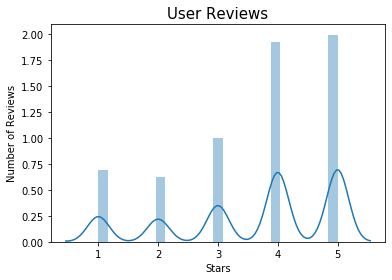

In [7]:
## graph distribution of ratings
ax = sns.distplot(yelp_df['stars'], bins = 25)
ax.set(xlabel='Stars', ylabel='Number of Reviews')

plt.title('User Reviews', fontsize = 15)
plt.show()

The reviews are distributed mostly in the 4 - 5 star range. 

In [8]:
## sorted data with positive rating = 1 & negative rating = 0 identifiers
yelp_df = yelp_df[yelp_df['stars']!= 3]
yelp_df['Positively_Rated'] = np.where(yelp_df['stars']>3, 1, 0)

In [9]:
## data cleaning
yelp_df["NoPunctuation"] = yelp_df['text'].str.replace('[^\w\s]','')
yelp_df["NoPunctuation"]

stop = stopwords.words('english')
stop_not = [
    'us','Im', 'dont','also','Mr','I', 'They', 'My', 
    'This', 'Ive', 'really', 'The', 'It', 'Its', 'Their', 'We', 'go', 
    'would', 'place','get','time','one', 'got','even','always']
stop.extend(stop_not)

In [10]:
## apply stopwords to data
yelp_df['review_without_stopwords'] = yelp_df['NoPunctuation'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

yelp_df['review_without_stopwords']

0        Hoagie institution Walking seem like throwback...
1        Excellent food Superb customer service miss ma...
2        Yes little dated opened weekend But staff plea...
3        All food great But best thing wings wings simp...
5        Wing sauce like water Pretty much lot butter h...
                               ...                        
27284    outstanding worth finding Kendra great waitres...
27285    Ok figured ordinary diner food best wrong fant...
27286    Love food atmosphere eat days week staff excit...
27288                          Horrible showers nice folks
27289    Stopped way Fort Jackson great neighborhood ri...
Name: review_without_stopwords, Length: 22910, dtype: object

In [11]:
## tokenize the data
yelp_df['review_tokenized'] = yelp_df['review_without_stopwords'].apply(word_tokenize)

In [12]:
## retrieve 10 most frequent words 
all_freq = yelp_df['review_tokenized'] 
freq_frame = all_freq.to_frame()

full_list = [] 
for element in freq_frame['review_tokenized']:  
    full_list += element 
    
all_counts = pd.Series(full_list).value_counts() 
all_counts[:10]

food       11124
good       11096
great       8462
like        8447
service     6398
back        6189
nice        4280
best        4037
well        3834
little      3634
dtype: int64

In [13]:
## vectorize & divert into training/test categories
pd.crosstab(index = yelp_df['Positively_Rated'], columns="Total count")
X_train, X_test, y_train, y_test = train_test_split(yelp_df['text'], yelp_df['Positively_Rated'],test_size = .1, random_state=1)

vect = CountVectorizer().fit(X_train)
X_train_vectorized = vect.transform(X_train)

In [14]:
## set up LogisticRegression & fit model
model = LogisticRegression(solver='liblinear')
model.fit(X_train_vectorized, y_train)

prediction = model.predict(vect.transform(X_test))

In [15]:
## set up roc_auc
print('AUC: ', roc_auc_score(y_test, prediction))
f_positive, t_positive, thresholds = roc_curve(y_test, prediction)

roc_auc = auc(f_positive, t_positive)

AUC:  0.893865024561823


In [16]:
## fitted CountVectorizer to training data 
## doc freq of 5, extract 1 gram & 2 gram
vect = CountVectorizer(min_df = 5, ngram_range = (1, 2)).fit(X_train)
X_train_vectorized = vect.transform(X_train)

model = LogisticRegression(max_iter = 10000)
model.fit(X_train_vectorized, y_train)

predictions = model.predict(vect.transform(X_test))
f_positive, t_positive, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(f_positive, t_positive)
print(roc_auc)

0.9040688926752957
